In [1]:
import sys; sys.path.append("../src")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from model.autoencoder import IsometricAE
from model.cmpnts import MLP

# Data
Let the manifold be an arc of length 4.

In [3]:
t = torch.linspace(0, 4, 50)
x = torch.cos(t)
y = torch.sin(t)

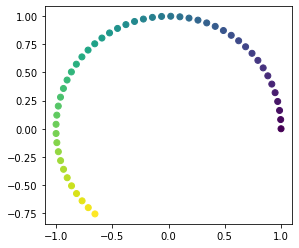

In [4]:
plt.scatter(x, y, c=t)
plt.gca().set_aspect('equal')
plt.show()

In [5]:
dataset = torch.stack([x, y], dim=-1)

# Loss

In [6]:
import functorch as ft

def loss_rec(x, x_hat):
    return F.mse_loss(x, x_hat)

def loss_iso(decoder, z, v, k, n=None):
    f = lambda z: decoder(z)
    jvp = ft.jvp(f, (z[:n],), (v[:n],))[1]
    norm = jvp.flatten(1).norm(dim=1)
    return F.mse_loss(norm, torch.ones_like(norm))

def loss_piso(encoder, x, v, k, n=None):
    g = lambda x: encoder(x)
    vjp, = ft.vjp(g, x[:n])[1](v[:n]) # i.e., vjp_fn(v)
    norm = vjp.flatten(1).norm(dim=1)
    return F.mse_loss(norm, torch.ones_like(norm))

def loss(x, encoder, decoder, k=1, n=None):
    z = encoder(x)
    x_hat = decoder(z)
    v = F.normalize(torch.randn_like(z), dim=1)
    return loss_rec(x, x_hat), loss_iso(decoder, z, v, k, n), loss_piso(encoder, x, v, k, n)

def loss_(x, encoder, decoder):
    z = encoder(x)
    x_hat = decoder(z)
    return loss_rec(x, x_hat)

# Model
## Sigmoid

Epoch 0: loss_rec=0.8710508942604065, loss_iso=0.9995403289794922, loss_piso=0.9989124536514282


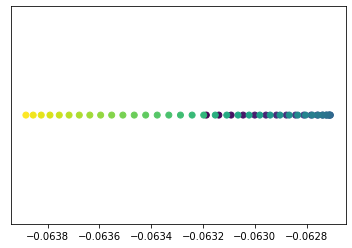

Epoch 999: loss_rec=0.4046705961227417, loss_iso=0.994143545627594, loss_piso=0.005154093727469444
Epoch 1999: loss_rec=0.36509156227111816, loss_iso=0.7630241513252258, loss_piso=0.04702220484614372


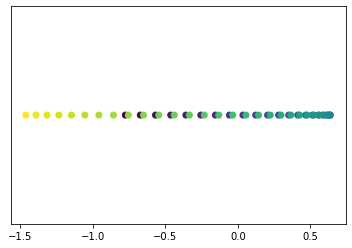

Epoch 2999: loss_rec=0.1255578249692917, loss_iso=0.2021961659193039, loss_piso=0.008830752223730087
Epoch 3999: loss_rec=0.08351779729127884, loss_iso=0.08654682338237762, loss_piso=0.003898077644407749


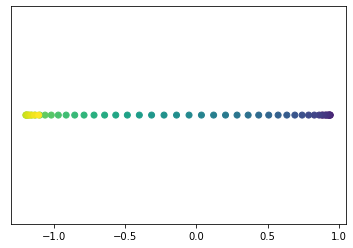

Epoch 4999: loss_rec=0.026656348258256912, loss_iso=0.03478904068470001, loss_piso=0.026307879015803337
Epoch 5999: loss_rec=0.013102181255817413, loss_iso=0.04440517723560333, loss_piso=0.028068942949175835


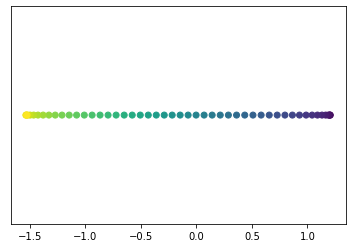

Epoch 6999: loss_rec=0.00742292869836092, loss_iso=0.020576927810907364, loss_piso=0.025738971307873726
Epoch 7999: loss_rec=0.0027755526825785637, loss_iso=0.008477797731757164, loss_piso=0.007845216430723667


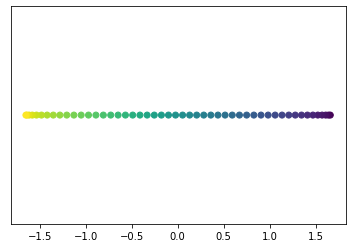

Epoch 8999: loss_rec=0.0011916228104382753, loss_iso=0.005239514168351889, loss_piso=0.0026204439345747232
Epoch 9999: loss_rec=0.0005328122060745955, loss_iso=0.002683208556845784, loss_piso=0.0014833243330940604


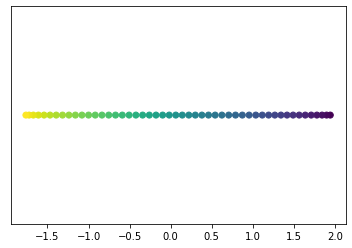

Epoch 10999: loss_rec=0.00023817546025384218, loss_iso=0.0014970549382269382, loss_piso=0.0006686773267574608
Epoch 11999: loss_rec=0.00011195767001481727, loss_iso=0.0009104625205509365, loss_piso=0.00041354616405442357


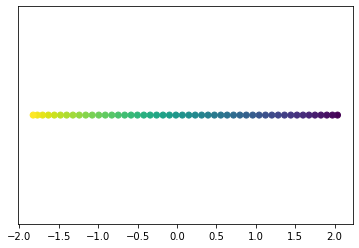

Epoch 12999: loss_rec=5.230779424891807e-05, loss_iso=0.00047843012725934386, loss_piso=0.0002651760296430439
Epoch 13999: loss_rec=2.334104101464618e-05, loss_iso=0.00023547440650872886, loss_piso=0.0001437390164937824


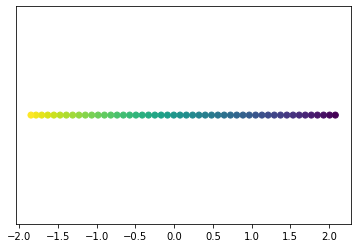

Epoch 14999: loss_rec=1.1749932127713691e-05, loss_iso=0.00014239753363654017, loss_piso=9.216788021149114e-05
Epoch 15999: loss_rec=7.102977178874426e-06, loss_iso=9.000005957204849e-05, loss_piso=6.526902143377811e-05


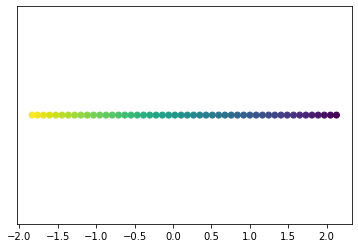

Epoch 16999: loss_rec=4.556375643005595e-06, loss_iso=5.527715984499082e-05, loss_piso=4.7015528252813965e-05
Epoch 17999: loss_rec=2.973525170091307e-06, loss_iso=3.318756716907956e-05, loss_piso=3.4698856325121596e-05


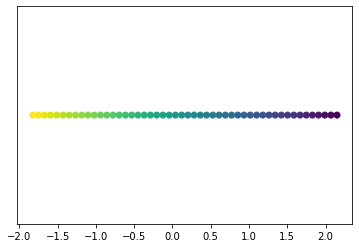

Epoch 18999: loss_rec=1.8899733049693168e-06, loss_iso=1.9514589439495467e-05, loss_piso=2.55408558587078e-05
Epoch 19999: loss_rec=1.2313290653764852e-06, loss_iso=1.2309955309319776e-05, loss_piso=1.935503132699523e-05


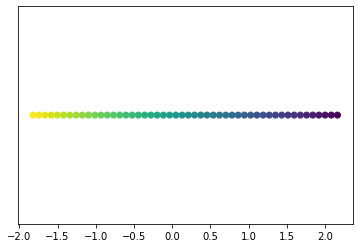

In [71]:
encoder = nn.Sequential(nn.Linear(2, 32), nn.Sigmoid(), nn.Linear(32, 32), nn.Sigmoid(), nn.Linear(32, 32), nn.Sigmoid(), nn.Linear(32, 1))
decoder = nn.Sequential(nn.Linear(1, 32), nn.Sigmoid(), nn.Linear(32, 32), nn.Sigmoid(), nn.Linear(32, 32), nn.Sigmoid(), nn.Linear(32, 2))

optim = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for epoch in range(20000):
    optim.zero_grad()
    l_rec, l_iso, l_piso = loss(dataset, encoder, decoder, k=1)
    l = l_rec + 0.05 * (l_iso + l_piso)
    l.backward()
    optim.step()

    if epoch == 0 or (epoch+1) % 1000 == 0:
        print('Epoch {}: loss_rec={}, loss_iso={}, loss_piso={}'.format(epoch, l_rec, l_iso, l_piso))
    if epoch == 0 or (epoch+1) % 2000 == 0:
        prd = encoder(dataset).detach().cpu()
        plt.scatter(prd, torch.zeros_like(prd), c=t)
        plt.yticks([])
        # plt.gca().set_aspect('equal')
        plt.show()

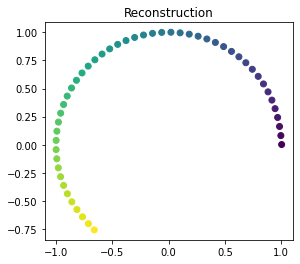

In [72]:
rec = decoder(prd).detach()
plt.scatter(rec[:, 0], rec[:, 1], c=t)
plt.gca().set_aspect('equal')
plt.title('Reconstruction')
plt.show()

In [73]:
print((prd.max() - prd.min()).item())

3.9824185371398926


**Comment:** Very close to the true length 4.

## ReLU

Epoch 0: loss_rec=0.6619263291358948, loss_iso=0.9449008107185364, loss_piso=0.9504694938659668


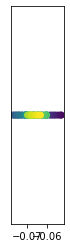

Epoch 999: loss_rec=0.015149520710110664, loss_iso=0.05843484029173851, loss_piso=0.03499337658286095
Epoch 1999: loss_rec=0.0014274597633630037, loss_iso=0.020351935178041458, loss_piso=0.01947130635380745


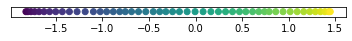

Epoch 2999: loss_rec=0.0004198229289613664, loss_iso=0.005533816292881966, loss_piso=0.009398898109793663
Epoch 3999: loss_rec=0.00012316610082052648, loss_iso=0.0021704360842704773, loss_piso=0.005060103721916676


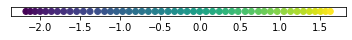

Epoch 4999: loss_rec=4.270906720194034e-05, loss_iso=0.001296097645536065, loss_piso=0.004101354628801346
Epoch 5999: loss_rec=1.1262719453952741e-05, loss_iso=0.00189478590618819, loss_piso=0.002733728615567088


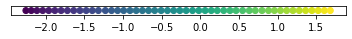

Epoch 6999: loss_rec=3.429994831094518e-05, loss_iso=0.0014223908074200153, loss_piso=0.005052607040852308
Epoch 7999: loss_rec=6.506690988317132e-05, loss_iso=0.0015741075621917844, loss_piso=0.016495220363140106


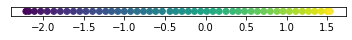

Epoch 8999: loss_rec=5.119538400322199e-05, loss_iso=0.0012112542754039168, loss_piso=0.010290131904184818
Epoch 9999: loss_rec=0.00013148109428584576, loss_iso=0.0027643239591270685, loss_piso=0.02094004862010479


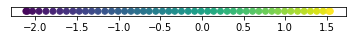

Epoch 10999: loss_rec=0.0002447302977088839, loss_iso=0.004554310813546181, loss_piso=0.037816401571035385
Epoch 11999: loss_rec=0.00023885814880486578, loss_iso=0.004683175124228001, loss_piso=0.03265789523720741


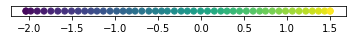

Epoch 12999: loss_rec=0.0002463938435539603, loss_iso=0.0038172700442373753, loss_piso=0.03827722743153572
Epoch 13999: loss_rec=0.00027159249293617904, loss_iso=0.004934460390359163, loss_piso=0.038710638880729675


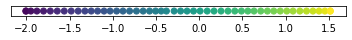

Epoch 14999: loss_rec=0.00026796484598889947, loss_iso=0.004428797867149115, loss_piso=0.03682985156774521
Epoch 15999: loss_rec=0.00025580593501217663, loss_iso=0.0046793934889137745, loss_piso=0.03633561357855797


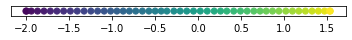

Epoch 16999: loss_rec=0.0002430111780995503, loss_iso=0.00427177594974637, loss_piso=0.036366455256938934
Epoch 17999: loss_rec=0.00024462147848680615, loss_iso=0.0041265906766057014, loss_piso=0.03684701770544052


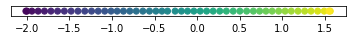

Epoch 18999: loss_rec=0.00024131391546688974, loss_iso=0.004213286563754082, loss_piso=0.03632232919335365
Epoch 19999: loss_rec=0.0002600695297587663, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


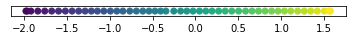

In [74]:
encoder = nn.Sequential(nn.Linear(2, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
decoder = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 2))

optim = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for epoch in range(20000):
    optim.zero_grad()
    l_rec, l_iso, l_piso = loss(dataset, encoder, decoder)
    l = l_rec + 0.05 * (l_iso + l_piso)
    l.backward()
    optim.step()

    if epoch == 0 or (epoch+1) % 1000 == 0:
        print('Epoch {}: loss_rec={}, loss_iso={}, loss_piso={}'.format(epoch, l_rec, l_iso, l_piso))
    if epoch == 0 or (epoch+1) % 2000 == 0:
        prd = encoder(dataset).detach().cpu()
        plt.scatter(prd, torch.zeros_like(prd), c=t)
        plt.yticks([])
        plt.gca().set_aspect('equal')
        plt.show()

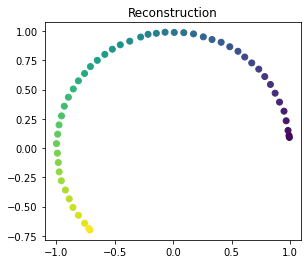

In [75]:
rec = decoder(prd).detach()
plt.scatter(rec[:, 0], rec[:, 1], c=t)
plt.gca().set_aspect('equal')
plt.title('Reconstruction')
plt.show()

In [76]:
print((prd.max() - prd.min()).item())

3.5438179969787598


## Without Isometric Loss

Epoch 0: loss_rec=0.47650250792503357, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


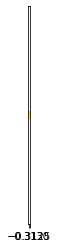

Epoch 999: loss_rec=0.3656999468803406, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 1999: loss_rec=0.10324300825595856, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


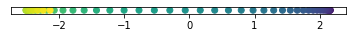

Epoch 2999: loss_rec=0.05662689357995987, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 3999: loss_rec=0.013782682828605175, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


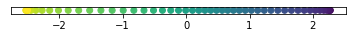

Epoch 4999: loss_rec=0.007201087661087513, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 5999: loss_rec=0.00181800767313689, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


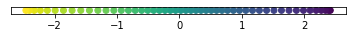

Epoch 6999: loss_rec=0.0006398229161277413, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 7999: loss_rec=0.00031762130674906075, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


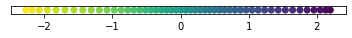

Epoch 8999: loss_rec=0.00012034008250338957, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 9999: loss_rec=4.566221105051227e-05, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


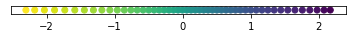

Epoch 10999: loss_rec=2.5683208150439896e-05, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 11999: loss_rec=1.5163494026637636e-05, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


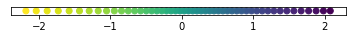

Epoch 12999: loss_rec=8.59037390910089e-06, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 13999: loss_rec=4.9153009058500174e-06, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


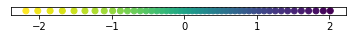

Epoch 14999: loss_rec=3.1177305572782643e-06, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 15999: loss_rec=2.218870577053167e-06, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


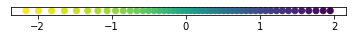

Epoch 16999: loss_rec=1.7871753925646772e-06, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 17999: loss_rec=1.4825113794358913e-06, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


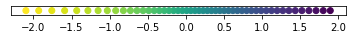

Epoch 18999: loss_rec=1.268018991140707e-06, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364
Epoch 19999: loss_rec=1.1192032616236247e-06, loss_iso=0.005370653234422207, loss_piso=0.037453148514032364


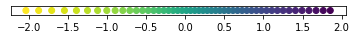

In [77]:
encoder = nn.Sequential(nn.Linear(2, 32), nn.Sigmoid(), nn.Linear(32, 32), nn.Sigmoid(), nn.Linear(32, 32), nn.Sigmoid(), nn.Linear(32, 1))
decoder = nn.Sequential(nn.Linear(1, 32), nn.Sigmoid(), nn.Linear(32, 32), nn.Sigmoid(), nn.Linear(32, 32), nn.Sigmoid(), nn.Linear(32, 2))

optim = Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for epoch in range(20000):
    optim.zero_grad()
    l_rec = loss_(dataset, encoder, decoder)
    l = l_rec
    l.backward()
    optim.step()

    if epoch == 0 or (epoch+1) % 1000 == 0:
        print('Epoch {}: loss_rec={}, loss_iso={}, loss_piso={}'.format(epoch, l_rec, l_iso, l_piso))
    if epoch == 0 or (epoch+1) % 2000 == 0:
        prd = encoder(dataset).detach().cpu()
        plt.scatter(prd, torch.zeros_like(prd), c=t)
        plt.yticks([])
        plt.gca().set_aspect('equal')
        plt.show()

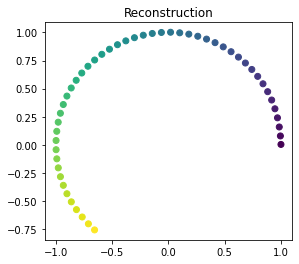

In [78]:
rec = decoder(prd).detach()
plt.scatter(rec[:, 0], rec[:, 1], c=t)
plt.gca().set_aspect('equal')
plt.title('Reconstruction')
plt.show()

In [79]:
print((prd.max() - prd.min()).item())

3.897496461868286
